In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df_train = pd.read_pickle("../data/df_train.pkl")
df_test = pd.read_pickle("../data/df_test.pkl")

In [4]:
df_train_X = df_train.drop(columns = ["cleavage_freq"])
df_train_y = df_train["cleavage_freq"]

### Preprocessing

In [5]:
class Preprocessing:
    def fold_seq(df):
        df["stacked"] = df["grna_target_sequence"].apply(lambda x: x.tolist()) + df["target_sequence"].apply(lambda x: x.tolist())
        df["stacked"] = df["stacked"].apply(lambda x: np.array(x))
    
    def tensorfy(stacked):
        temp = []
        for i in stacked:
            temp.append(i)
        return torch.from_numpy(np.array(temp).astype(np.float32))

In [6]:
Preprocessing.fold_seq(df_train_X)
X = Preprocessing.tensorfy(df_train_X["stacked"])

In [7]:
#np.array(df_train_y).reshape(df_train_y.shape[0], 1)

In [8]:
y = torch.Tensor(np.array(df_train_y).reshape(df_train_y.shape[0], 1).astype(np.float32))

### Model

In [9]:
train_ds = TensorDataset(X, y)

In [10]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[0.7500, 0.2500, 1.0000, 0.7500, 1.0000, 0.2500, 0.5000, 0.2500, 0.2500,
          0.2500, 0.7500, 0.2500, 0.5000, 0.7500, 0.2500, 0.7500, 0.2500, 1.0000,
          0.7500, 1.0000, 0.5000, 0.7500, 0.7500, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7500, 0.2500, 1.0000, 0.7500,
          1.0000, 0.2500, 0.5000, 0.2500, 0.2500, 0.2500, 0.7500, 0.2500, 0.5000,
          0.7500, 0.5000, 0.7500, 0.2500, 0.7500, 0.7500, 1.0000, 0.5000, 0.7500,
          0.7500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.7500, 0.2500, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.000

In [11]:
model = nn.Linear(100, 1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[-0.0244, -0.0648, -0.0476, -0.0802,  0.0867, -0.0849,  0.0310, -0.0395,
         -0.0088, -0.0131, -0.0985,  0.0136, -0.0692,  0.0350, -0.0429,  0.0910,
         -0.0252, -0.0027,  0.0628, -0.0730,  0.0214,  0.0214,  0.0712,  0.0878,
          0.0059,  0.0476, -0.0373, -0.0482, -0.0006, -0.0432,  0.0614,  0.0994,
          0.0513, -0.0020, -0.0401,  0.0996,  0.0738, -0.0541, -0.0080, -0.0897,
          0.0928, -0.0406, -0.0348,  0.0721, -0.0051,  0.0158,  0.0688,  0.0071,
         -0.0731,  0.0832,  0.0406,  0.0912,  0.0543, -0.0144,  0.0838,  0.0879,
          0.0599,  0.0351,  0.0354, -0.0289,  0.0026, -0.0054,  0.0972,  0.0950,
         -0.0417, -0.0398,  0.0851,  0.0144,  0.0297, -0.0474, -0.0195,  0.0377,
          0.0536,  0.0999, -0.0915,  0.0316,  0.0498,  0.0924,  0.0466, -0.0590,
         -0.0373, -0.0840, -0.0461,  0.0944,  0.0887,  0.0673, -0.0164,  0.0307,
          0.0278, -0.0494, -0.0639, -0.0973, -0.0366, -0.0357, -0.0852,  0.0743,
      

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [13]:
loss_fn = F.mse_loss

In [14]:
loss = loss_fn(model(X), y)
print(loss)

tensor(0.0938, grad_fn=<MseLossBackward>)


In [15]:
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(X), y))

In [16]:
fit(100, model, loss_fn, opt)

Training loss:  tensor(0.0368, grad_fn=<MseLossBackward>)


In [17]:
preds = model(X)
preds

tensor([[ 0.0064],
        [ 0.0692],
        [ 0.0454],
        ...,
        [ 0.1543],
        [-0.0080],
        [ 0.0575]], grad_fn=<AddmmBackward>)

In [18]:
y

tensor([[7.0066e-05],
        [1.4500e-04],
        [5.1200e-04],
        ...,
        [1.0640e-03],
        [1.9703e-02],
        [2.3380e-06]])

In [19]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr


def benchmark(predictions, actuals):
    predictions = predictions.detach().numpy()
    actuals = actuals.detach().numpy()
    mse = mean_squared_error(y_true=actuals, y_pred=predictions)
    correlation, pvalue = spearmanr(a=actuals, b=predictions)

    return {
        'mean_squared_error': mse,
        'spearman_rank': {
            'correlation':  correlation,
            'pvalue': pvalue,
        }
    }

In [20]:
benchmark(preds, y)

{'mean_squared_error': 0.0367975,
 'spearman_rank': {'correlation': 0.1210440962503619,
  'pvalue': 1.4018598149223927e-67}}

In [21]:
preds = preds.reshape(preds.shape[0],)
y = y.reshape(y.shape[0],)

In [22]:
preds = preds.detach().numpy()
y = y.detach().numpy()

In [23]:
v = pd.DataFrame(preds, columns = ["preds"])

In [24]:
v["y"] = y
v

,preds,y
0,0.006380,0.000070
1,0.069195,0.000145
2,0.045436,0.000512
3,0.094309,0.000035
4,0.002964,0.000109
...,...,...
20438,0.048059,0.002479
20439,0.058425,0.000176
20440,0.154294,0.001064
20441,-0.007978,0.019703


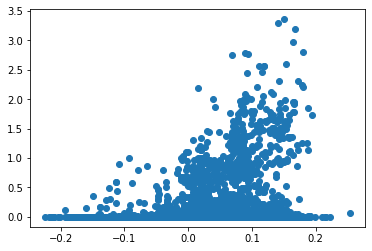

In [25]:
plt.scatter(v["preds"], v["y"])

In [26]:
v = v[v["y"] > 0.2]

In [27]:
v

,preds,y
16,0.187391,1.137556
33,0.088921,2.775273
86,0.066491,0.312305
163,0.081629,0.470600
166,0.021648,0.793148
...,...,...
20306,0.019799,0.666007
20330,0.084805,1.958181
20372,0.072564,1.340597
20388,0.051556,0.411203


In [28]:
y.shape

(20443,)

In [29]:
# 728/20443 ~ 3.6% of data high cleavage frequencies that model doesn't predict